In [1]:
from typing import Any

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision.models.resnet import resnet18, ResNet18_Weights

from torchmetrics import Accuracy

import pytorch_lightning as L
from pytorch_lightning.utilities.types import STEP_OUTPUT

# TODO: Check if at least !!!CLASSES!!! are seperable in UMAP !!!
#### Shoudl definitely be the case

In [2]:
transform = T.ToTensor()

In [32]:
class Resnet18Clf(L.LightningModule):
    def __init__(self, in_channels=3, num_cls=2,*args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)

        # self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model = resnet18()
        self.model.fc = torch.nn.Linear(512, num_cls)
        self.model.conv1 = torch.nn.Conv2d(
            in_channels, 64, kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(params=self.parameters(), lr=1e-4)
        self.metric = Accuracy(num_classes=2, multiclass=True)

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X)
        loss = self.criterion(y, t)

        self.log("loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X).argmax(dim=1)
        
        accuracy = self.metric(y, t)

        self.log('accuracy', accuracy)

        return accuracy
    
    def configure_optimizers(self) -> Any:
        return self.optimizer

### Camelyon

In [33]:
from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader, get_train_loader

In [34]:
from wilds.common.grouper import CombinatorialGrouper

In [35]:
dataset = get_dataset("camelyon17", root_dir="../../data/")
train_set = dataset.get_subset("train", transform=transform)
val_set = dataset.get_subset("id_val", transform=transform)
test_set = dataset.get_subset('test', transform=transform)

grouper = CombinatorialGrouper(dataset, ['hospital'])

train_loader = get_train_loader("standard", train_set, grouper=grouper,uniform_over_groups=True, batch_size=128, num_workers=8)
val_loader = get_eval_loader('standard', val_set, batch_size=64, num_workers=8)
test_loader = get_eval_loader('standard', test_set, batch_size=64, num_workers=8)

In [36]:
trainer = L.Trainer(
    accelerator="auto", 
    max_epochs=5, 
    val_check_interval=int(len(train_loader)/3)
)

model = Resnet18Clf(num_cls=2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/yasin/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
source_set = dataset.get_subset("train", transform=transform, frac=10_000/len(train_set))
target_set = dataset.get_subset("test", transform=transform, frac=10_000/len(test_set))

In [10]:
source_loader = get_eval_loader("standard", source_set, batch_size=64, num_workers=8)
target_loader = get_eval_loader("standard", target_set, batch_size=64, num_workers=8)

In [11]:
model_ = model.model.cuda()
model_.fc = torch.nn.Identity()

In [12]:
from tqdm import tqdm

In [13]:
source_embeddings = []
source_targets = []

target_embeddings = []
target_targets = []

with torch.no_grad():
    for X, t, _ in tqdm(source_loader):
        source_embeddings.append(model_(X.cuda()))
        source_targets.append(t)

    for X, t, _ in tqdm(target_loader):
        target_embeddings.append(model_(X.cuda()))
        target_targets.append(t)

source_embeddings = torch.cat(source_embeddings, dim=0)
source_targets = torch.cat(source_targets, dim=0)
target_embeddings = torch.cat(target_embeddings, dim=0)
target_targets = torch.cat(target_targets, dim=0)

100%|██████████| 157/157 [00:01<00:00, 90.87it/s] 


In [14]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [15]:
reducer = umap.UMAP(n_neighbors=15, n_epochs=1000, min_dist=0.1, verbose=True)

In [16]:
all_embeddings = torch.cat([source_embeddings, target_embeddings],dim=0).cpu()
all_targets = torch.cat([source_targets, target_targets], dim=0).cpu()

In [17]:
all_embeddings.shape, all_targets.shape

(torch.Size([20000, 512]), torch.Size([20000]))

In [18]:
X_scaled = StandardScaler().fit_transform(all_embeddings.cpu())

In [19]:
X_reduced = reducer.fit_transform(X_scaled)

UMAP(n_epochs=1000, verbose=True)
Tue Dec  5 13:22:58 2023 Construct fuzzy simplicial set
Tue Dec  5 13:22:58 2023 Finding Nearest Neighbors
Tue Dec  5 13:22:58 2023 Building RP forest with 12 trees
Tue Dec  5 13:23:00 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Dec  5 13:23:06 2023 Finished Nearest Neighbor Search
Tue Dec  5 13:23:07 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Dec  5 13:23:27 2023 Finished embedding


In [20]:
source_target = torch.cat([torch.zeros(10_000), torch.ones(10_000)])

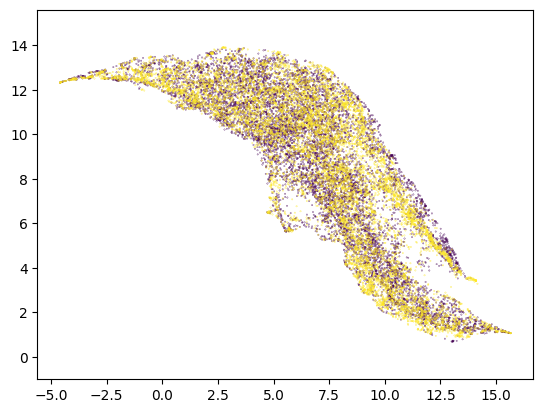

In [22]:
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=source_target,
    s=0.05
)
plt.gca().set_aspect('equal', 'datalim')